In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import os
import pandas as pd

# Path to the directory containing the image files
#change the path
directory ='C://Users/gauth/OneDrive/Desktop/DIP Project/g4'

# List to store extracted information
data = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    # Split filename by ".chip" to get the main part
    main_part = filename.split(".chip")[0]

    # Split main part by "_" to extract age and gender
    age, gender, *rest = main_part.split("_")

    # Convert gender to string representation
    gender = "Male" if gender == "0" else "Female"

    # Join the rest of the filename back together (if any)
    rest = "_".join(rest)

    # Append extracted information to the list
    data.append({'Filename': filename, 'Age': int(age), 'Gender': gender})

# Create DataFrame from the extracted information
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


                                              Filename  Age  Gender
0    10_0_0_20170110225505288.jpg.chip - Copy - Cop...   10    Male
1    10_0_0_20170110225601897.jpg.chip - Copy - Cop...   10    Male
2    10_0_0_20170116201337172.jpg.chip - Copy - Cop...   10    Male
3    10_0_0_20170117135444407.jpg.chip - Copy - Cop...   10    Male
4               116_1_2_20170112220255503.jpg.chip.jpg  116  Female
..                                                 ...  ...     ...
490  7_0_0_20170110215620675.jpg.chip - Copy - Copy...    7    Male
491  7_0_0_20170110215633251.jpg.chip - Copy - Copy...    7    Male
492              85_1_0_20170110182128680.jpg.chip.jpg   85  Female
493              96_1_2_20170110182504813.jpg.chip.jpg   96  Female
494              96_1_2_20170110182526540.jpg.chip.jpg   96  Female

[495 rows x 3 columns]


In [3]:
import numpy as np
import cv2
import os
import os
from ultralytics import YOLO


#loading caffe models
ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"

genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']




#path for images
#please change the path here also.
folder_path = 'C://Users/gauth/OneDrive/Desktop/DIP PROJECT/g4'

# List all image files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) ]
#No of images
print(len(image_files))


# Iterate over each image
result_list=[]
#yolo model being used for face detection
model=YOLO("yolov8n-face.pt")
for image_file in image_files:
    # Read image
    img = cv2.imread(image_file)
    #getting results yolo model
    results=model(img)
    result_list.append(results)
    boxes=results[0].boxes


    #looping over the faces detected from yolo
    for box in boxes:
        top_left_x=int(box.xyxy.tolist()[0][0])
        top_left_y=int(box.xyxy.tolist()[0][1])
        bottom_right_x=int(box.xyxy.tolist()[0][2])
        bottom_right_y=int(box.xyxy.tolist()[0][3])

        cv2.rectangle(img,( top_left_x,top_left_y),(bottom_right_x,  bottom_right_y),(255,0,0),2)
        #detected face region
        detected_face=img[top_left_y:bottom_right_y,  top_left_x:bottom_right_x]
        #Bicubic interpolation
        detected_face=cv2.resize(detected_face, (227, 227), interpolation=cv2.INTER_CUBIC)
        cv2.imshow("resized face",detected_face)
        lab_img= cv2.cvtColor(detected_face, cv2.COLOR_BGR2LAB)

        #Splitting the LAB image to L, A and B channels, respectively
        l, a, b = cv2.split(lab_img)


        #Apply histogram equalization to the L channel
        equ = cv2.equalizeHist(l)

        #Combine the Hist. equalized L-channel back with A and B channels
        updated_lab_img1 = cv2.merge((equ,a,b))

        #Convert LAB image back to color (RGB)
        hist_eq_img = cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
        #cv2.imshow('histogram equalization img', hist_eq_img)
        

        #clahe equalization
        #Apply CLAHE to L channel
        #with 16,16 tile size
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16,16))
        clahe_img = clahe.apply(l)
        

        #Combine the CLAHE enhanced L-channel back with A and B channels
        updated_lab_img2 = cv2.merge((clahe_img,a,b))

        #Convert LAB image back to color (RGB)
        CLAHE_img = cv2.cvtColor(updated_lab_img2, cv2.COLOR_LAB2BGR)
        #cv2.imshow('CLAHE img', CLAHE_img)
      
        detected_face_blob = cv2.dnn.blobFromImage(CLAHE_img, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)


        genderNet.setInput(detected_face_blob)
        ageNet.setInput(detected_face_blob)

        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]


        agePreds=ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        print("gender",gender,"age",age)


        label = "{}{}".format(gender,age)

        cv2.putText(img, label, (top_left_x+20, top_left_y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

        #loading predicted results to the existing df
        df.loc[df['Filename'] == os.path.basename(image_file), 'Predicted_Gender'] = gender
        df.loc[df['Filename'] == os.path.basename(image_file), 'Predicted_Age'] = age
    #cv2.imshow("ok",img)

    cv2.waitKey(0)




cv2.destroyAllWindows()





495

0: 448x640 1 face, 305.8ms
Speed: 26.9ms preprocess, 305.8ms inference, 4500.3ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 248.9ms
Speed: 9.2ms preprocess, 248.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (8-12)

0: 448x640 1 face, 208.1ms
Speed: 0.0ms preprocess, 208.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (38-43)

0: 448x640 2 faces, 178.7ms
Speed: 3.7ms preprocess, 178.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)
gender Male age (25-32)

0: 448x640 1 face, 223.8ms
Speed: 6.8ms preprocess, 223.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Female age (60-100)

0: 448x640 2 faces, 225.1ms
Speed: 0.0ms preprocess, 225.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (60-100)
gender Male age (60-100)

0: 448x640 1 face, 242.2ms
Speed: 11.

Speed: 0.0ms preprocess, 219.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (4-6)

0: 448x640 2 faces, 256.0ms
Speed: 2.8ms preprocess, 256.0ms inference, 4.8ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (0-2)
gender Male age (4-6)

0: 448x640 2 faces, 299.3ms
Speed: 0.0ms preprocess, 299.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (0-2)
gender Female age (4-6)

0: 448x640 2 faces, 260.0ms
Speed: 0.0ms preprocess, 260.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)
gender Male age (4-6)

0: 448x640 1 face, 255.1ms
Speed: 3.8ms preprocess, 255.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (8-12)

0: 448x640 1 face, 240.7ms
Speed: 0.0ms preprocess, 240.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (38-43)

0: 448x640 1 face, 187.8ms
Speed: 16.3ms preprocess, 187.8ms in

gender Male age (25-32)
gender Male age (25-32)

0: 448x640 1 face, 218.7ms
Speed: 0.0ms preprocess, 218.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 2 faces, 219.1ms
Speed: 0.0ms preprocess, 219.1ms inference, 12.5ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)
gender Female age (4-6)

0: 448x640 1 face, 208.9ms
Speed: 15.8ms preprocess, 208.9ms inference, 4.1ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 152.9ms
Speed: 1.2ms preprocess, 152.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (48-53)

0: 448x640 1 face, 250.9ms
Speed: 15.7ms preprocess, 250.9ms inference, 15.6ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (0-2)

0: 448x640 1 face, 235.3ms
Speed: 0.0ms preprocess, 235.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (48-53)

0: 448x640 1 face, 243.6

Speed: 14.0ms preprocess, 237.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 251.6ms
Speed: 0.0ms preprocess, 251.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 252.5ms
Speed: 15.6ms preprocess, 252.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 257.3ms
Speed: 0.0ms preprocess, 257.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 263.5ms
Speed: 1.6ms preprocess, 263.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 236.8ms
Speed: 0.0ms preprocess, 236.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (38-43)

0: 448x640 1 face, 236.4ms
Speed: 0.0ms preprocess, 236.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


gender Male age (8-12)

0: 448x640 2 faces, 268.5ms
Speed: 0.0ms preprocess, 268.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)
gender Male age (25-32)

0: 448x640 1 face, 236.5ms
Speed: 9.5ms preprocess, 236.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 253.1ms
Speed: 0.0ms preprocess, 253.1ms inference, 14.5ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 254.6ms
Speed: 0.0ms preprocess, 254.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 220.8ms
Speed: 0.0ms preprocess, 220.8ms inference, 15.6ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 237.2ms
Speed: 13.5ms preprocess, 237.2ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (8-12)

0: 448x640 1 face, 226.1ms
Speed: 8.3ms preproces

gender Male age (38-43)

0: 448x640 1 face, 146.1ms
Speed: 4.2ms preprocess, 146.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 148.1ms
Speed: 9.0ms preprocess, 148.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 157.9ms
Speed: 8.2ms preprocess, 157.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 200.6ms
Speed: 4.5ms preprocess, 200.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 199.5ms
Speed: 8.6ms preprocess, 199.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 189.3ms
Speed: 10.7ms preprocess, 189.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Female age (25-32)

0: 448x640 1 face, 211.2ms
Speed: 0.0ms preprocess, 211.2ms inference, 0

Speed: 1.2ms preprocess, 174.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Female age (25-32)

0: 448x640 1 face, 205.0ms
Speed: 0.0ms preprocess, 205.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 2 faces, 149.8ms
Speed: 7.2ms preprocess, 149.8ms inference, 7.8ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)
gender Male age (38-43)

0: 448x640 1 face, 236.3ms
Speed: 2.4ms preprocess, 236.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 154.0ms
Speed: 3.5ms preprocess, 154.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (4-6)

0: 448x640 1 face, 158.3ms
Speed: 6.5ms preprocess, 158.3ms inference, 7.2ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 2 faces, 154.8ms
Speed: 10.2ms preprocess, 154.8ms inference, 0.0ms postprocess per image a

gender Male age (25-32)

0: 448x640 1 face, 203.0ms
Speed: 7.9ms preprocess, 203.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 2 faces, 276.8ms
Speed: 16.2ms preprocess, 276.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (38-43)
gender Male age (25-32)

0: 448x640 2 faces, 252.5ms
Speed: 15.8ms preprocess, 252.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)
gender Male age (25-32)

0: 448x640 1 face, 236.7ms
Speed: 7.6ms preprocess, 236.7ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 2 faces, 260.9ms
Speed: 0.0ms preprocess, 260.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)
gender Male age (25-32)

0: 448x640 1 face, 200.5ms
Speed: 7.0ms preprocess, 200.5ms inference, 4.6ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (38-43)

gender Female age (25-32)

0: 448x640 1 face, 181.1ms
Speed: 6.6ms preprocess, 181.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 2 faces, 157.9ms
Speed: 8.6ms preprocess, 157.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)
gender Female age (48-53)

0: 448x640 2 faces, 188.3ms
Speed: 10.9ms preprocess, 188.3ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Female age (25-32)
gender Female age (38-43)

0: 448x640 (no detections), 183.1ms
Speed: 7.2ms preprocess, 183.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 face, 150.8ms
Speed: 0.0ms preprocess, 150.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (48-53)

0: 448x640 1 face, 157.5ms
Speed: 3.6ms preprocess, 157.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Female age (25-32)

0: 448x640 2 faces, 174.5ms
S

gender Male age (48-53)

0: 448x640 2 faces, 178.6ms
Speed: 0.0ms preprocess, 178.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)
gender Male age (25-32)

0: 448x640 1 face, 153.8ms
Speed: 6.3ms preprocess, 153.8ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (48-53)

0: 448x640 1 face, 159.1ms
Speed: 2.3ms preprocess, 159.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (8-12)

0: 448x640 1 face, 210.0ms
Speed: 7.9ms preprocess, 210.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (25-32)

0: 448x640 1 face, 223.9ms
Speed: 0.0ms preprocess, 223.9ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)
gender Female age (25-32)

0: 448x640 1 face, 205.4ms
Speed: 4.1ms preprocess, 205.4ms inference, 5.4ms postprocess per image at shape (1, 3, 448, 640)
gender Male age (8-12)

0: 448x640 1 face, 175.1ms
Speed: 0.0ms preprocess

In [4]:
# Calculate accuracy for predicted age
correct_age_predictions = 0
for index, row in df.iterrows():
    actual_age = row['Age']
    predicted_age_range = row['Predicted_Age']
    if isinstance(predicted_age_range, str):  # Check if the predicted age range is a string
        predicted_age_start, predicted_age_end = map(int, predicted_age_range.strip('()').split('-'))  # Extract start and end of predicted age range
        if actual_age >= predicted_age_start and actual_age <= predicted_age_end:
            correct_age_predictions += 1

total_images = df.shape[0]
age_accuracy = correct_age_predictions / total_images * 100



# Calculate accuracy for predicted gender
correct_gender_predictions = (df['Gender'] == df['Predicted_Gender']).sum()
gender_accuracy = correct_gender_predictions / total_images * 100

# Print results
print("Accuracy for predicted age: {:.2f}%".format(age_accuracy))
print("Accuracy for predicted gender: {:.2f}%".format(gender_accuracy))

Accuracy for predicted age: 50.10%
Accuracy for predicted gender: 65.86%


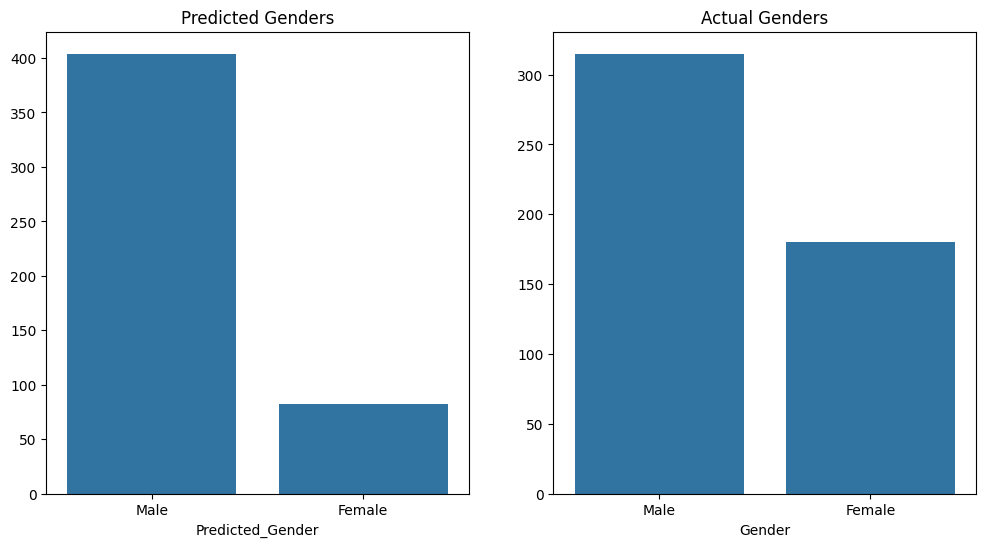

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' contains the DataFrame with columns 'Predicted_Gender' and 'Gender'
# Replace 'df' with the actual DataFrame name if different
# Replace 'Predicted_Gender' and 'Gender' with the actual column names if different

# Count the occurrences of predicted and actual genders
predicted_gender_counts = df['Predicted_Gender'].value_counts()
actual_gender_counts = df['Gender'].value_counts()

# Create a figure and axis object
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot predicted genders
sns.barplot(x=predicted_gender_counts.index, y=predicted_gender_counts.values, ax=axes[0])
axes[0].set_title('Predicted Genders')

# Plot actual genders
sns.barplot(x=actual_gender_counts.index, y=actual_gender_counts.values, ax=axes[1])
axes[1].set_title('Actual Genders')

# Adjust layout to prevent overlap


# Show the plot
plt.show()


C:\Users\gauth\AppData\Local\Temp\ipykernel_11132\4158931325.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=predicted_age_counts.index, y=predicted_age_counts.values, ax=axes[0], palette="muted")
C:\Users\gauth\AppData\Local\Temp\ipykernel_11132\4158931325.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=actual_age_counts.index, y=actual_age_counts.values, ax=axes[1], palette="muted")


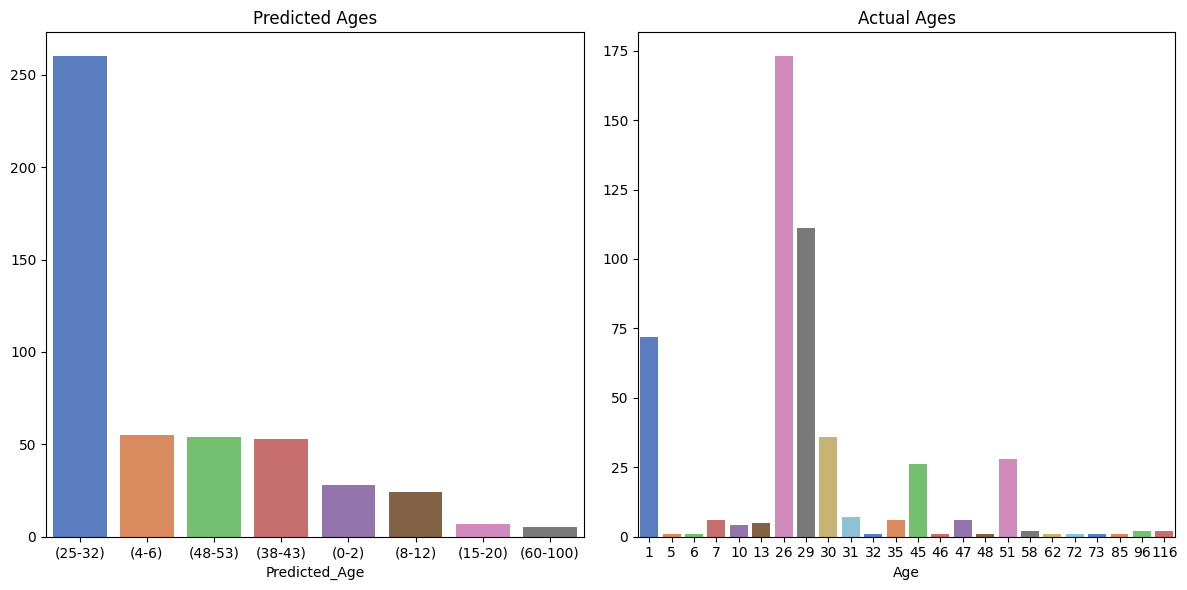

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of predicted and actual ages
predicted_age_counts = df['Predicted_Age'].value_counts()
actual_age_counts = df['Age'].value_counts()

# Create a figure and axis object
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot predicted ages
sns.barplot(x=predicted_age_counts.index, y=predicted_age_counts.values, ax=axes[0], palette="muted")
axes[0].set_title('Predicted Ages')

# Plot actual ages
sns.barplot(x=actual_age_counts.index, y=actual_age_counts.values, ax=axes[1], palette="muted")
axes[1].set_title('Actual Ages')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


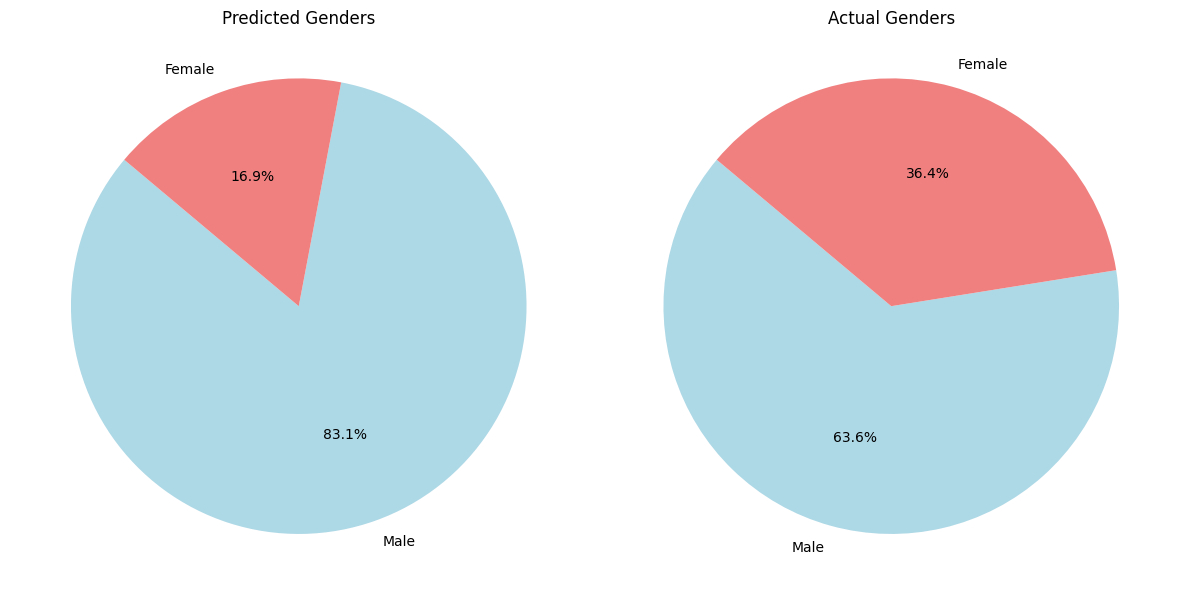

In [7]:


# Assuming 'df' contains the DataFrame with columns 'Predicted_Gender' and 'Gender'
# Replace 'df' with the actual DataFrame name if different
# Replace 'Predicted_Gender' and 'Gender' with the actual column names if different

# Count the occurrences of predicted and actual genders
predicted_gender_counts = df['Predicted_Gender'].value_counts()
actual_gender_counts = df['Gender'].value_counts()

# Create a figure and axis object
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create a pie chart for predicted genders
axes[0].pie(predicted_gender_counts, labels=predicted_gender_counts.index, colors=['lightblue', 'lightcoral'], autopct='%1.1f%%', startangle=140)
axes[0].set_title('Predicted Genders')
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Create a pie chart for actual genders
axes[1].pie(actual_gender_counts, labels=actual_gender_counts.index, colors=['lightblue', 'lightcoral'], autopct='%1.1f%%', startangle=140)
axes[1].set_title('Actual Genders')
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


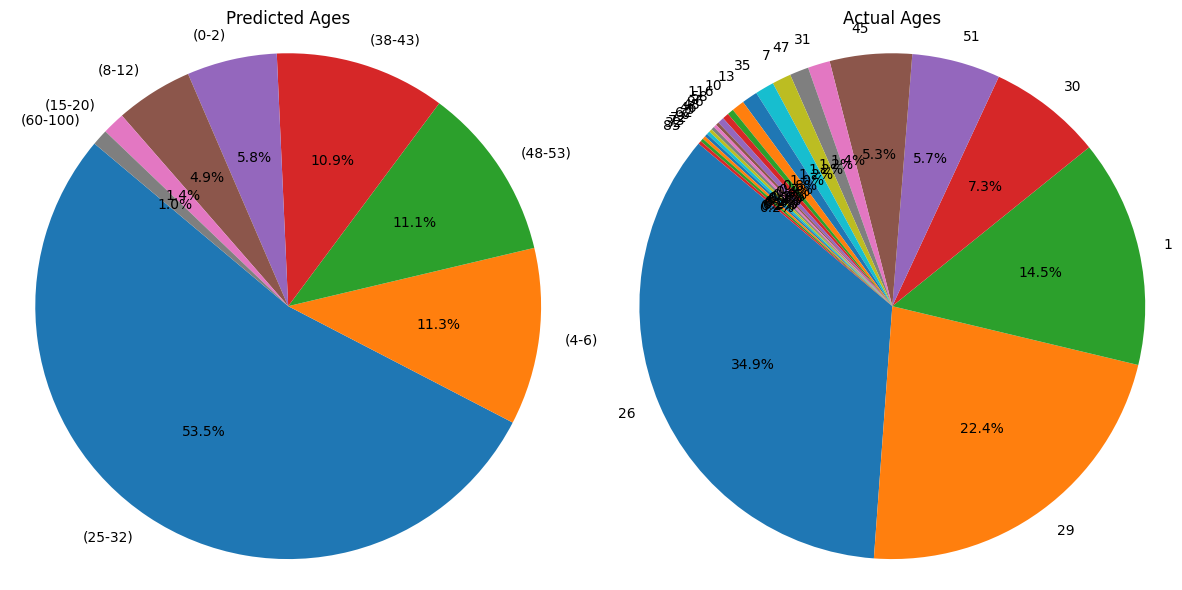

In [8]:
import matplotlib.pyplot as plt



# Create separate figures for ages
plt.figure(figsize=(12, 6))

# Plot pie chart for predicted ages
plt.subplot(1, 2, 1)
plt.pie(predicted_age_counts, labels=predicted_age_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Predicted Ages')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Plot pie chart for actual ages
plt.subplot(1, 2, 2)
plt.pie(actual_age_counts, labels=actual_age_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Actual Ages')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots for ages
plt.show()
